In [ ]:
import pandas as pd
import biom
import qiime2
import numpy as np
import os

from metagpt import ask
from openai import OpenAI

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
%matplotlib inline

ID = 'sample_name'
HBS = 'host_body_site'
HLS = 'host_life_stage'
HSID = 'host_subject_id'
AGE = 'host_age'
PID = 'pair_id'
COLD = 'collection_date'

meta = pd.read_csv('meta/metadata-fromqiita-2024-12-11-15626_20241124-130942.txt', sep='\t')

meta = pd.read_csv('meta/metadata-modified.tsv', sep='\t')
meta.equals(meta2)

False

In [250]:
cols = [PID, COLD, 'days_since_baseline', 'days_since_start_abx', HLS,
            'host_age', 'child_age', 'n_samples_per_pair', 'study_group', 'antibiotic',
            ]

In [251]:
def save_meta():
    meta.to_csv('meta/metadata-modified.tsv', sep='\t', index=False)
    
def load_meta():
    return pd.read_csv('meta/metadata-modified.tsv', sep='\t')

### ID pair column
Make a column that ids and matches an infant to a mother.

In [ ]:
ids = list(meta[HSID])
ids_number = [x.split('.')[0] for x in ids]
meta['pair_id'] = ids_number

save_meta()

/Users/daniperry/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/seaborn/_core.py:973: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
/Users/daniperry/anaconda3/envs/qiime2-amplicon-2024.5/lib/python3.9/site-packages/seaborn/_core.py:991: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'host_age by host_life_stage')

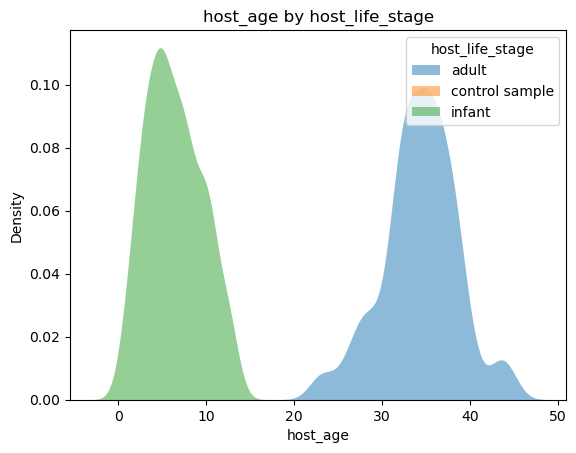

In [252]:
# Code adapted from LMNOP

m = meta[[HSID, 'pair_id', AGE, HLS]]
    
num_col = AGE
cat_col = HLS

df = m[[num_col, cat_col]]
df = df.dropna()
df[num_col] = pd.to_numeric(df[num_col], errors='coerce')
df[cat_col] = df[cat_col].astype('category')
df = df.dropna()

fig, ax = plt.subplots()
sns.kdeplot(
    data=df,
    x=num_col,
    hue=cat_col,
    fill=True, common_norm=False,
    alpha=.5, linewidth=0, ax=ax
)

ax.set_title(f'{num_col} by {cat_col}')

### What is the distribution of infant age?

This along with the above plot tells us that the scale of infant age is probably months while the mother's age is in years.

In [253]:
x = meta[meta[HLS] == 'infant'][AGE]
x = pd.to_numeric(x, errors='coerce')
print(f'max value of infant age: {max(x)}')
print(f'min value of infant age: {min(x)}')


max value of infant age: 13.6
min value of infant age: 0.23


## Days since collection columns

The time points for these collections will be at the initiation of the antibiotic treatment (Day 1), at the mid-point of the antibiotic treatment (Day 5-7) and at the end of the antibiotic treatment (Day 10-14) (Figure 2)

<img src='meta/png/collection-scheme.png' width=700px>

In [257]:
import pandas as pd
from datetime import datetime

meta = load_meta()
if 'days_since_start_abx' not in meta.columns:
    meta['collection_date'] = pd.to_datetime(meta['collection_date'], errors='coerce')

    first_observations = meta.groupby('pair_id')['collection_date'].min().reset_index()
    first_observations.rename(columns={'collection_date': 'baseline_date'}, inplace=True)

    temp_df = meta.copy()
    temp_df = temp_df.merge(first_observations, on='pair_id', how='left')
    temp_df = temp_df[temp_df['collection_date'] > temp_df['baseline_date']]

    second_observations = temp_df.groupby('pair_id')['collection_date'].min().reset_index()
    second_observations.rename(columns={'collection_date': 'start_abx_date'}, inplace=True)

    meta = meta.merge(first_observations, on='pair_id', how='left')
    meta = meta.merge(second_observations, on='pair_id', how='left')

    meta['days_since_baseline'] = (meta['collection_date'] - meta['baseline_date']).dt.total_seconds() / (24 * 60 * 60)
    meta['days_since_start_abx'] = (meta['collection_date'] - meta['start_abx_date']).dt.total_seconds() / (24 * 60 * 60)
    meta.to_csv('meta/metadata-modified.tsv', sep='\t', index=False)

# Number of samples per pair ID (should be 8 according to scheme)
meta['n_samples_per_pair'] = 0
meta.set_index(ID, inplace=True)
for g, gr in meta.groupby(PID):
    ids = list(gr.index)
    meta.loc[ids, 'n_samples_per_pair'] = len(ids)
    # display(gr[cols].sort_values(by='days_since_baseline'))
meta.reset_index(inplace=True)

save_meta()

### Timepoint id for which timepoints are linked together

In [260]:
meta = load_meta()

meta['timepoint_pair_id'] = meta[ID].str.split('.').str[-1]
if 'timepoint_pair_id' not in cols:
    cols.append('timepoint_pair_id')
meta.loc[meta[ID].str.contains('BLANK'), 'timepoint_pair_id'] = 'control sample'
for g, gr in meta.groupby('pair_id'):
    print(gr[cols].sort_values(by='days_since_baseline'))
    
save_meta()

  pair_id collection_date  days_since_baseline  days_since_start_abx  \
3   12081      2022-05-22                  0.0                -110.0   
7   12081      2022-05-22                  0.0                -110.0   
0   12081      2022-09-09                110.0                   0.0   
4   12081      2022-09-09                110.0                   0.0   
1   12081      2022-09-14                115.0                   5.0   
5   12081      2022-09-14                115.0                   5.0   
2   12081      2022-09-19                120.0                  10.0   
6   12081      2022-09-19                120.0                  10.0   

  host_life_stage host_age child_age  n_samples_per_pair study_group  \
3          infant      4.3       4.3                   8    Baseline   
7           adult     31.9       4.3                   8    Baseline   
0          infant     7.86      7.86                   8  BF, No ABX   
4           adult     32.2      7.86                   8  BF, N

## Antibiotic column

We have the following four classes of antibiotics according to the grant:
- amoxicillin
- amoxicillin/clavulanate
- azithromycin
- nitrofurantoin

And observe the following antibiotics:

In [261]:
meta.antibiotic.value_counts()

antibiotic
control sample     99
Amoxicillin        88
Cephalexin         35
Augmentin          22
Azithromycin       12
Penicillin         11
Keflex             10
Macrobid            8
Doxycycline         6
Metronidazole       6
Bactrim             6
Clindamycin         4
Nitrofurantonin     2
Name: count, dtype: int64

### Make a new antibiotic column that has all babies and mothers with the filled in antibiotic by pair_id
Also add no abx for a value

In [262]:
set(meta['study_group'])

{'ABX Exposed', 'BF, No ABX', 'Baseline', 'No BF, ABX', 'control sample', nan}

In [220]:
set(meta['antibiotic2'])

for g, gr in meta.groupby(PID):
    print(gr[cols].sort_values(by='days_since_baseline'))


                                      pair_id collection_date  \
sample_name                                                     
15626.12081.Infant.Baseline.22STL6415   12081      2022-05-22   
15626.12081.Mom.Baseline.22STL6415      12081      2022-05-22   
15626.12081.Infant.BFNoABX.22STL6566    12081      2022-09-09   
15626.12081.Mom.BFNoABX.22STL6566       12081      2022-09-09   
15626.12081.Infant.BFNoABX.22STL6567    12081      2022-09-14   
15626.12081.Mom.BFNoABX.22STL6567       12081      2022-09-14   
15626.12081.Infant.BFNoABX.22STL6568    12081      2022-09-19   
15626.12081.Mom.BFNoABX.22STL6568       12081      2022-09-19   

                                       days_since_baseline  \
sample_name                                                  
15626.12081.Infant.Baseline.22STL6415                  0.0   
15626.12081.Mom.Baseline.22STL6415                     0.0   
15626.12081.Infant.BFNoABX.22STL6566                 110.0   
15626.12081.Mom.BFNoABX.22STL6566      

In [264]:
meta = load_meta()

meta.set_index(ID, inplace=True)
meta['antibiotic2'] = ''

if 'antibiotic2' not in cols:
    cols.append('antibiotic2')

for g, gr in meta.groupby(PID):
    # display(gr[cols].sort_values(by='days_since_start_abx'))
    ids = list(gr.index)
    # meta.loc[ids,'']
    sg  = set(gr['study_group'])
    # There are some caveats with incomplete blocks
    if len(gr) == 8: 
        if 'ABX Exposed' in sg:
            print(gr[cols])
            abx = [x for x in set(gr['antibiotic']) if type(x) == str][0]
            meta.loc[ids, 'antibiotic2'] = abx
        else:
            meta.loc[ids, 'antibiotic2'] = 'no abx'

save_meta()          

                                        pair_id collection_date  \
sample_name                                                       
15626.12121.Infant.ABXExposed.22STL6422   12121      2022-06-04   
15626.12121.Infant.ABXExposed.22STL6423   12121      2022-06-07   
15626.12121.Infant.ABXExposed.22STL6424   12121      2022-06-10   
15626.12121.Infant.Baseline.22STL6418     12121      2022-06-02   
15626.12121.Mom.ABXExposed.22STL6422      12121      2022-06-04   
15626.12121.Mom.ABXExposed.22STL6423      12121      2022-06-07   
15626.12121.Mom.ABXExposed.22STL6424      12121      2022-06-10   
15626.12121.Mom.Baseline.22STL6418        12121      2022-06-02   

                                         days_since_baseline  \
sample_name                                                    
15626.12121.Infant.ABXExposed.22STL6422                  2.0   
15626.12121.Infant.ABXExposed.22STL6423                  5.0   
15626.12121.Infant.ABXExposed.22STL6424                  8.0   
15626.121

In [265]:
meta

,aliquot,anonymized_name,antibiotic,bag_location,biospecimen_id,child_age,collection_date,collection_timestamp,country,date_of_stool_collection,...,tube_id,user_id,pair_id,baseline_date,start_abx_date,days_since_baseline,days_since_start_abx,n_samples_per_pair,timepoint_pair_id,antibiotic2
sample_name,,,,,,,,,,,,,,,,,,,,,
15626.12081.Infant.BFNoABX.22STL6566,M1,22STL6566,NaN,1,22STL6566,7.86,2022-09-09,2022-09-09,USA,2022-09-09,...,364342877,12081,12081,2022-05-22,2022-09-09,110.0,0.0,8,22STL6566,no abx
15626.12081.Infant.BFNoABX.22STL6567,M1,22STL6567,NaN,1,22STL6567,8.03,2022-09-14,2022-09-14,USA,2022-09-14,...,364344876,12081,12081,2022-05-22,2022-09-09,115.0,5.0,8,22STL6567,no abx
15626.12081.Infant.BFNoABX.22STL6568,M1,22STL6568,NaN,1,22STL6568,8.2,2022-09-19,2022-09-19,USA,2022-09-19,...,364344878,12081,12081,2022-05-22,2022-09-09,120.0,10.0,8,22STL6568,no abx
15626.12081.Infant.Baseline.22STL6415,M1,22STL6415,NaN,1,22STL6415,4.3,2022-05-22,2022-05-22,USA,2022-05-22,...,364342870,12081,12081,2022-05-22,2022-09-09,0.0,-110.0,8,22STL6415,no abx
15626.12081.Mom.BFNoABX.22STL6566,M2,22STL6566,NaN,1,22STL6566,7.86,2022-09-09,2022-09-09,USA,2022-09-09,...,364342876,12081,12081,2022-05-22,2022-09-09,110.0,0.0,8,22STL6566,no abx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15626.BLANK.MRPINT.5.F8,control sample,control sample,control sample,control sample,control sample,control sample,NaN,2020-24-11,control sample,control sample,...,control sample,control sample,BLANK,NaN,NaN,NaN,NaN,99,control sample,
15626.BLANK.MRPINT.5.G12,control sample,control sample,control sample,control sample,control sample,control sample,NaN,2020-24-11,control sample,control sample,...,control sample,control sample,BLANK,NaN,NaN,NaN,NaN,99,control sample,
15626.BLANK.MRPINT.5.H11,control sample,control sample,control sample,control sample,control sample,control sample,NaN,2020-24-11,control sample,control sample,...,control sample,control sample,BLANK,NaN,NaN,NaN,NaN,99,control sample,


## Subjects who were recorded for a treatment of no abx and abx
There are some pairs who were observed at baseline, then start, then mid, then after, but didn't recieve abx, then again when they were recieving abx

In [182]:
meta['study_group'].unique()

array(['BF, No ABX', 'Baseline', 'ABX Exposed', 'No BF, ABX', nan,
       'control sample'], dtype=object)

In [180]:
meta['pair_id'].value_counts()

meta[meta['pair_id'] == '20033'][cols].sort_values(by='days_since_start_abx')

,pair_id,collection_date,days_since_baseline,days_since_start_abx,host_life_stage,host_age,child_age,n_samples_per_pair,study_group,antibiotic
sample_name,,,,,,,,,,
15626.20033.Infant.Baseline.23STL7614,20033,2023-09-06,0.0,-1.0,infant,1.93,1.93,10,Baseline,NaN
15626.20033.Mom.Baseline.23STL7614,20033,2023-09-07,1.0,0.0,adult,37.58,1.96,10,Baseline,NaN
15626.20033.Infant.BFNoABX.23STL7787,20033,2023-12-09,94.0,93.0,infant,5.03,5.03,10,"BF, No ABX",NaN
15626.20033.Mom.BFNoABX.23STL7787,20033,2023-12-09,94.0,93.0,adult,37.84,5.03,10,"BF, No ABX",NaN
15626.20033.Infant.BFNoABX.23STL7788,20033,2023-12-12,97.0,96.0,infant,5.13,5.13,10,"BF, No ABX",NaN
15626.20033.Mom.BFNoABX.23STL7788,20033,2023-12-12,97.0,96.0,adult,37.85,5.13,10,"BF, No ABX",NaN
15626.20033.Mom.ABXExposed.24STL8204,20033,2024-03-12,188.0,187.0,adult,38.1,8.13,10,ABX Exposed,Augmentin
15626.20033.Infant.ABXExposed.24STL8204,20033,2024-03-13,189.0,188.0,infant,8.16,8.16,10,ABX Exposed,Augmentin
15626.20033.Mom.ABXExposed.24STL8205,20033,2024-03-14,190.0,189.0,adult,38.1,8.2,10,ABX Exposed,Augmentin
